In [597]:
import pandas as pd
import math
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
import bt
from bt.core import Algo
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import risk_matrix
import numpy as np
from datetime import datetime
from pandas_datareader import data as wb
import datetime as dt
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [652]:
#main_tickers = ['FNTN.DE', 'NLM.F', 'MMK.VI', 'WIE.VI', 'FHZN.SW', 'KP5.F', 'LXS.DE', 'TGYM.MI', 'NDX1.DE', '39K.F', 'MOR.DE'] # , 'TMV.DE' #Data is imported from yahoo finance in the currency stated there
#main_tickers = ['VLUE', 'QUAL', 'MTUM', 'SIZE', 'USMV'] #US factor portfolio
#main_tickers = ['IVLU', 'IMTM', 'IQLT', 'ISZE', 'ACWV'] #International factor portfolio 
main_tickers = ['IVLU', 'IMTM', 'IQLT', 'ISZE', 'ACWV', 'VLUE', 'QUAL', 'MTUM', 'SIZE', 'USMV' ] # US + International Factor portfolio 

benchmark = ['^GDAXI']

main_benchmark_tickers = ['^GDAXI', 'IVLU', 'IMTM', 'IQLT', 'ISZE', 'ACWV', 'VLUE', 'QUAL', 'MTUM', 'SIZE', 'USMV' ]

today = dt.date.today()
start_date_input = today - dt.timedelta(days=365*5) #importing data five years back 



In [653]:
def import_stock_data(tickers, start, end = datetime.today().strftime('%Y-%m-%d')):
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = wb.DataReader(t, data_source='yahoo', start = start)['Adj Close']
    return(data)

plot_data = import_stock_data(tickers = main_benchmark_tickers, start = start_date_input).dropna()

data = import_stock_data(tickers = main_tickers, start = start_date_input).dropna()

data_benchmark = import_stock_data(tickers = benchmark, start = start_date_input).dropna()


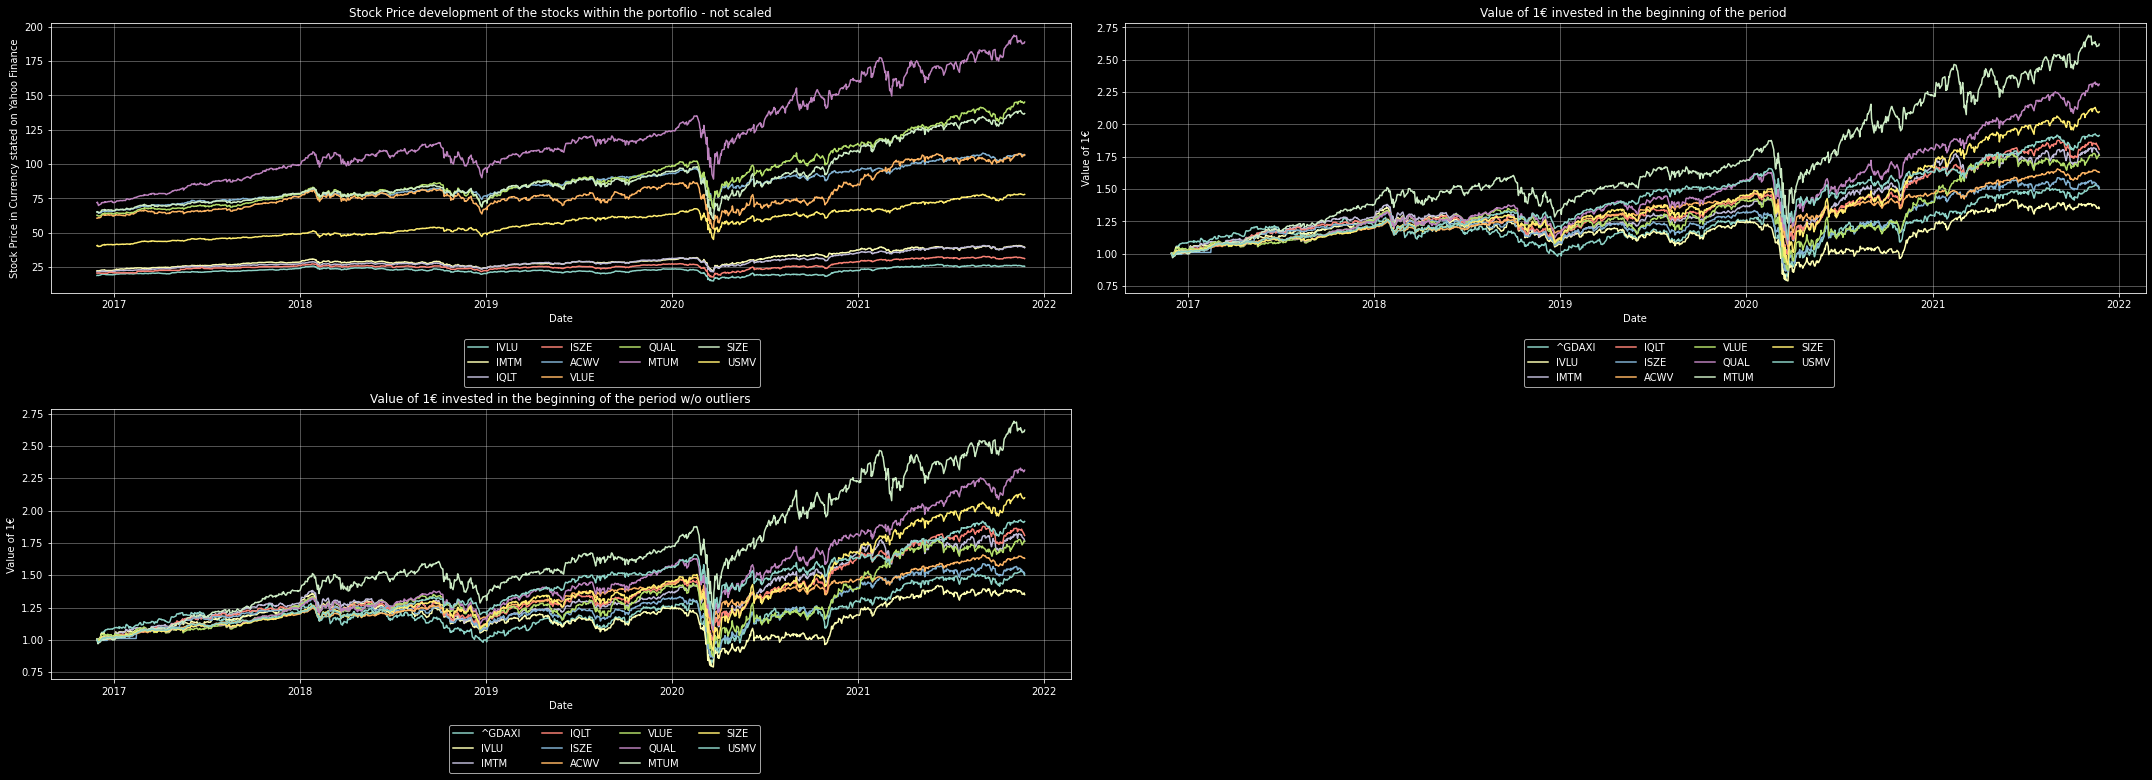

In [657]:
columns = data.columns
fig, ax = plt.subplots(figsize=(30,15))
plt.subplot(3,2,1)
for col in columns:
    plt.plot(data[col]) #Data plotted w/o the benchmark as it has to be scaled at times 
    plt.xlabel('Date')
    plt.ylabel('Stock Price in Currency stated on Yahoo Finance')
    plt.title('Stock Price development of the stocks within the portoflio - not scaled')
    plt.grid(alpha = 0.4)
    plt.legend(columns, ncol=4, fancybox=True, bbox_to_anchor=(0.70, -0.15))

columns = plot_data.columns
plt.subplot(3,2,2)
plt.plot((plot_data.pct_change() + 1).cumprod()) # value of 1€ invested in the beginning of the period 
plt.xlabel('Date')
plt.ylabel('Value of 1€')
plt.title('Value of 1€ invested in the beginning of the period ')
plt.grid(alpha = 0.4)
plt.legend(columns, ncol=4, fancybox=True, bbox_to_anchor=(0.70, -0.15))

#Removing outlier to see the returns better (if there are any)
plt.subplot(3,2,3)
plt.plot(((plot_data.loc[:, plot_data.columns!='KP5.F']).pct_change()+1).cumprod()) # value of 1€ invested in the beginning of the period 
plt.xlabel('Date')
plt.ylabel('Value of 1€')
plt.title('Value of 1€ invested in the beginning of the period w/o outliers')
plt.grid(alpha = 0.4)
plt.legend(columns, ncol=4, fancybox=True, bbox_to_anchor=(0.70, -0.15))

plt.tight_layout()

In [639]:
#creating the minimum volatility weight function to be used in the minvol algo
def calc_pypf_minvol_weights(prices):
    mu = mean_historical_return(prices, compounding= True)
    s  = risk_matrix(prices, method= "sample_cov")
    
    ef =  EfficientFrontier(mu, s)
    minvol_weights = ef.min_volatility()

    return minvol_weights

#create the weighminvol class to be used as an algo in the bt framework
class WeighMinVol(Algo):

    """
    Sets temp['weights'] based on minimum variance optimization.

    Sets the target weights based on calc_min_vol_weights.

    Args:
        * lookback (DateOffset): lookback period for estimating volatility
        * bounds ((min, max)): tuple specifying the min and max weights for
          each asset in the optimization.
        * covar_method (str): method used to estimate the covariance.
        * rf (float): risk-free rate used in optimization.

    Sets:
        * weights

    Requires:
        * selected
    """

    def __init__(
        self,
        lookback=pd.DateOffset(months=3),
        bounds=(0.0, 1.0),
        covar_method="ledoit-wolf",
        rf=0.0,
        lag=pd.DateOffset(days=0),
    ):
        super(WeighMinVol, self).__init__()
        self.lookback = lookback
        self.lag = lag
        self.bounds = bounds
        self.covar_method = covar_method
        self.rf = rf

    def __call__(self, target):
        selected = target.temp["selected"]

        if len(selected) == 0:
            target.temp["weights"] = {}
            return True

        if len(selected) == 1:
            target.temp["weights"] = {selected[0]: 1.0}
            return True

        t0 = target.now - self.lag
        prc = target.universe.loc[t0 - self.lookback : t0, selected]
        tw = calc_pypf_minvol_weights(prc)

        target.temp["weights"] = tw
        return True

In [662]:
weight_n = {"^GDAXI": 1000}

In [713]:
strategy_meanvar = bt.Strategy('Strategy Maximum Sharpe Ratio', [
                    bt.algos.RunMonthly(run_on_first_date=True, run_on_end_of_period=False),
                    
                    bt.algos.SelectHasData(),
                    bt.algos.WeighMeanVar(covar_method='standard'),
                    bt.algos.Rebalance()])

strategy_minvol = bt.Strategy('Strategy Minimum Volatility', [
                    bt.algos.RunMonthly(run_on_first_date=True, run_on_end_of_period=False),
                 
                    bt.algos.SelectHasData(),
                    WeighMinVol(covar_method='standard'),
                    bt.algos.Rebalance()])

strategy_1n =  bt.Strategy('Strategy 1/N', [
                    bt.algos.RunMonthly(run_on_first_date=True, run_on_end_of_period=False),
                    
                    bt.algos.SelectHasData(),
                    bt.algos.WeighEqually(),
                    bt.algos.Rebalance()])

strategy_invvol =  bt.Strategy('Strategy Inverse Volatility', [
                    bt.algos.RunMonthly(run_on_first_date=True, run_on_end_of_period=False),
                    
                    bt.algos.SelectHasData(),
                    bt.algos.WeighInvVol(),
                    bt.algos.Rebalance()])

strategy_erc =  bt.Strategy('Equal Risk Contribution', [
                    bt.algos.RunMonthly(run_on_first_date=True, run_on_end_of_period=False),
                    #bt.algos.RunAfterDate('2020-10-22'),
                    bt.algos.SelectHasData(),
                    bt.algos.WeighERC(covar_method='standard', risk_parity_method='ccd', maximum_iterations = 10000),
                    bt.algos.Rebalance()])

strategy_benchmark =  bt.Strategy('Strategy Benchmark', [
                    bt.algos.RunYearly(),
                    
                    bt.algos.SelectHasData(),
                    bt.algos.WeighEqually(),
                    bt.algos.Rebalance()])

In [714]:
#Markowitz portfolio
backtest_meanvar = bt.Backtest(strategy_meanvar, data)
result_meanvar   = bt.run(backtest_meanvar)

#Minimum Volatility
backtest_minvol = bt.Backtest(strategy_minvol, data)
result_minvol   = bt.run(backtest_minvol)

#1/N portfolio
backtest_1n = bt.Backtest(strategy_1n, data)
result_1n   = bt.run(backtest_1n)

#Inverse Volatility 
backtest_invvol = bt.Backtest(strategy_invvol, data)
result_invvol = bt.run(backtest_invvol)

#Equal Risk Contribution 
backtest_erc = bt.Backtest(strategy_erc, data)
result_erc = bt.run(backtest_erc)

#Benchmark 
backtest_benchmark = bt.Backtest(strategy_benchmark, data_benchmark)
result_benchmark   = bt.run(backtest_benchmark)

<AxesSubplot:xlabel='Date'>

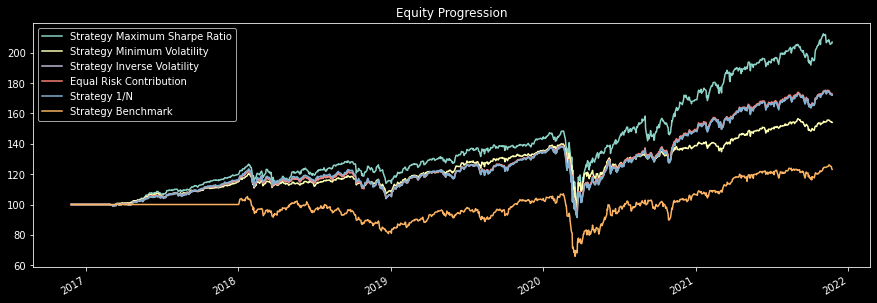

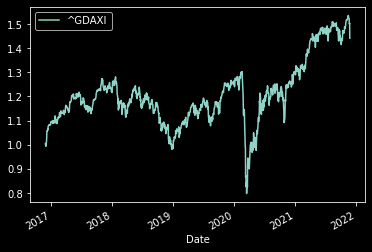

In [722]:
bt.run(backtest_meanvar, backtest_minvol, backtest_invvol, backtest_erc, backtest_1n, backtest_benchmark).plot()

(data_benchmark.pct_change()+1).cumprod().plot()

In [726]:
data_benchmark.pct_change().std()

^GDAXI    0.012042
dtype: float64

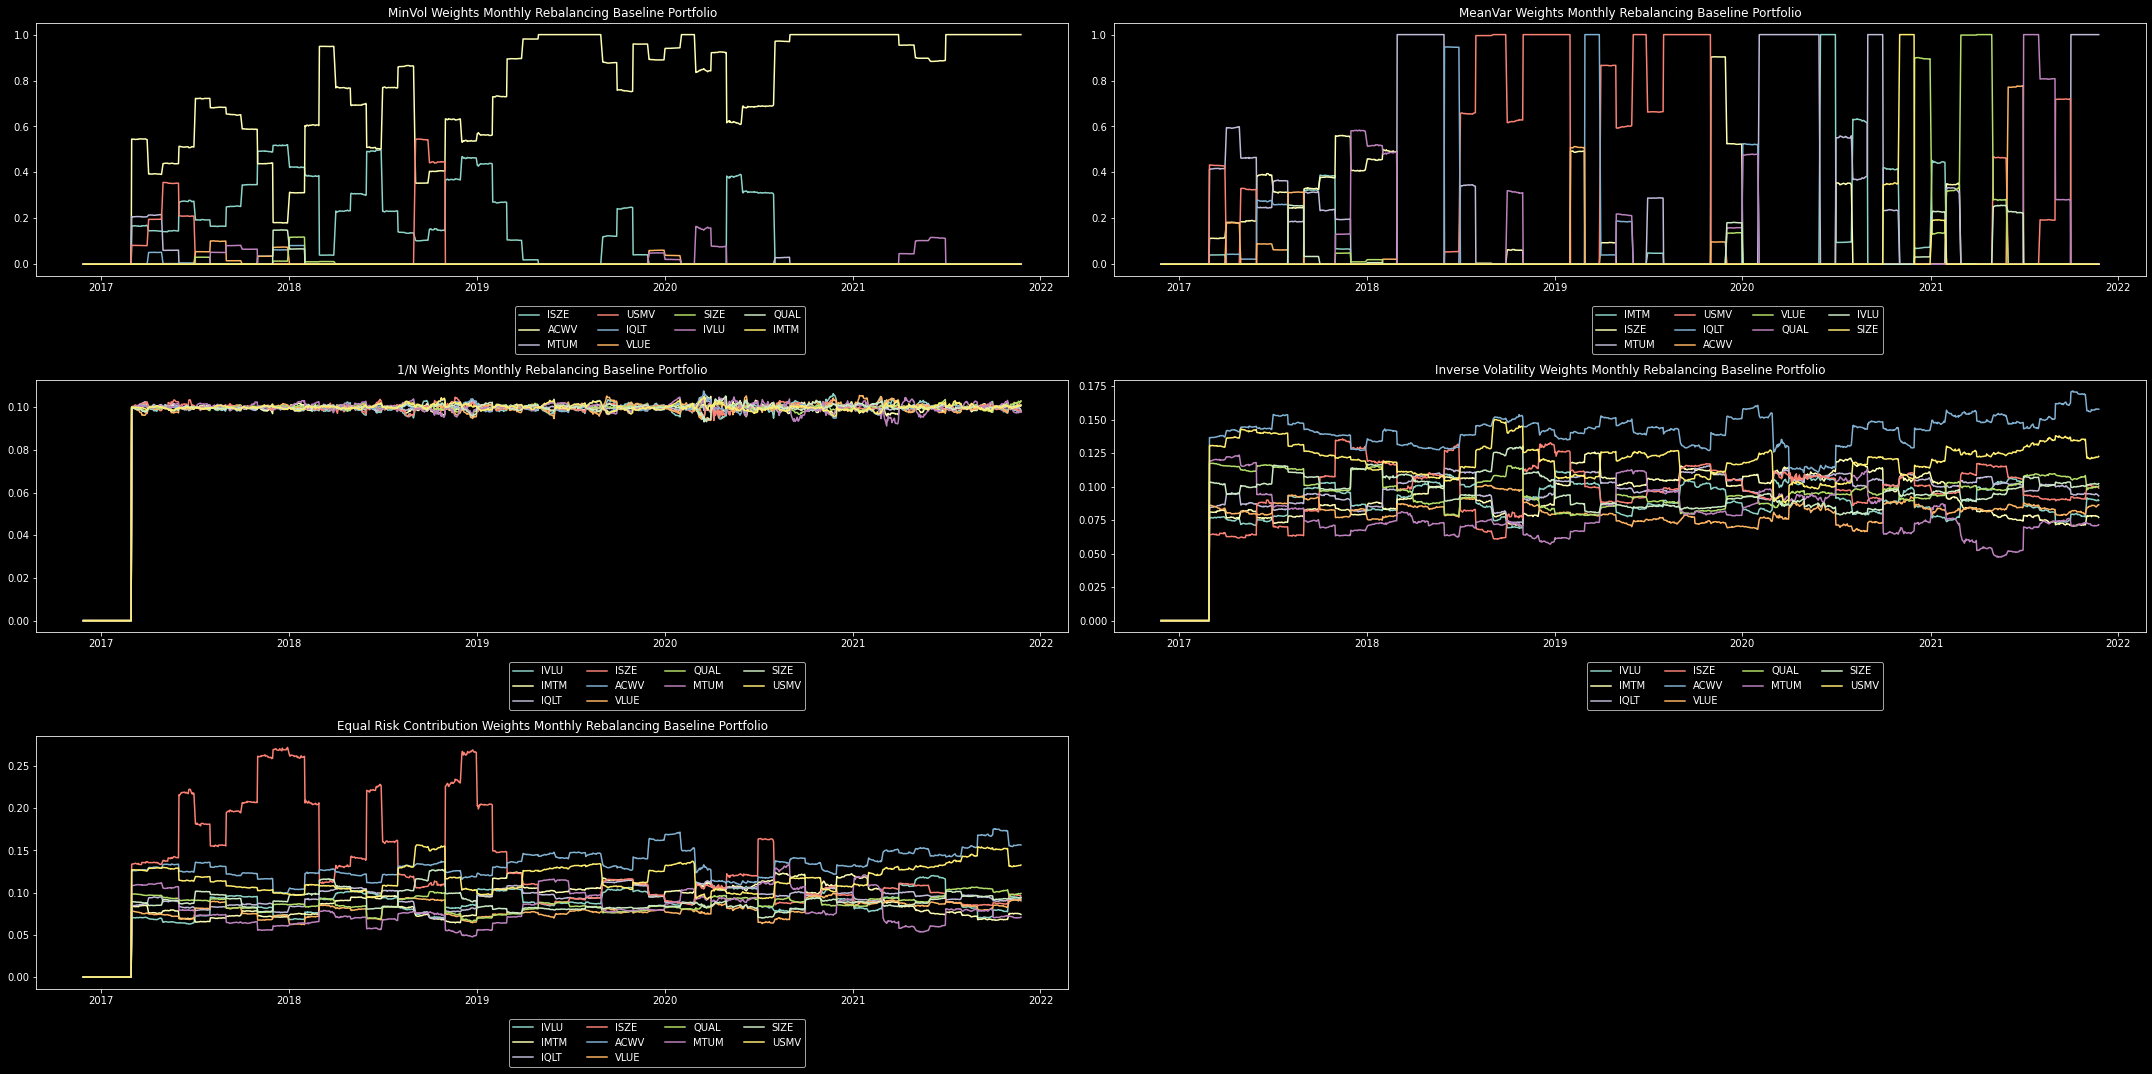

In [720]:
weights_meanvar = result_meanvar.get_security_weights()
weights_minvol = result_minvol.get_security_weights()
weights_1n = result_1n.get_security_weights()
weights_invvol = result_invvol.get_security_weights()
weights_erc = result_erc.get_security_weights()

#plotting the weights
fig, ax = plt.subplots(figsize=(30,15))

plt.subplot(3,2,1)
plt.plot(weights_minvol)
plt.title('MinVol Weights Monthly Rebalancing Baseline Portfolio')
plt.legend(labels = weights_minvol.columns, ncol=4, fancybox=True, bbox_to_anchor=(0.75, -0.1))

plt.subplot(3,2,2)
plt.plot(weights_meanvar)
plt.title('MeanVar Weights Monthly Rebalancing Baseline Portfolio')
plt.legend(labels = weights_meanvar.columns, ncol=4, fancybox=True, bbox_to_anchor=(0.75, -0.1))

plt.subplot(3,2,3)
plt.plot(weights_1n)
plt.title('1/N Weights Monthly Rebalancing Baseline Portfolio')
plt.legend(labels = weights_1n.columns, ncol=4, fancybox=True, bbox_to_anchor=(0.75, -0.1))

plt.subplot(3,2,4)
plt.plot(weights_invvol)
plt.title('Inverse Volatility Weights Monthly Rebalancing Baseline Portfolio')
plt.legend(labels = weights_invvol.columns, ncol=4, fancybox=True, bbox_to_anchor=(0.75, -0.1))

plt.subplot(3,2,5)
plt.plot(weights_erc)
plt.title('Equal Risk Contribution Weights Monthly Rebalancing Baseline Portfolio')
plt.legend(labels = weights_erc.columns, ncol=4, fancybox=True, bbox_to_anchor=(0.75, -0.1))

plt.tight_layout()

In [723]:
results = pd.DataFrame()
results = pd.DataFrame(index = result_meanvar.stats.index)
results["Strategy MSR"] = result_meanvar.stats
results["Strategy MinVol"] = result_minvol.stats
results["Strategy InvVol"] = result_invvol.stats
results["Equal Risk Contribution"] = result_erc.stats
results["Strategy 1/N"] = result_1n.stats
results

,Strategy MSR,Strategy MinVol,Strategy InvVol,Equal Risk Contribution,Strategy 1/N
start,2016-11-27 00:00:00,2016-11-27 00:00:00,2016-11-27 00:00:00,2016-11-27 00:00:00,2016-11-27 00:00:00
end,2021-11-24 00:00:00,2021-11-24 00:00:00,2021-11-24 00:00:00,2021-11-24 00:00:00,2021-11-24 00:00:00
rf,0.0,0.0,0.0,0.0,0.0
total_return,1.069303,0.540323,0.720716,0.727639,0.721056
cagr,0.156851,0.090409,0.114874,0.115772,0.114918
max_drawdown,-0.340816,-0.293894,-0.333578,-0.333382,-0.33846
calmar,0.460222,0.307624,0.34437,0.347264,0.339533
mtd,-0.009911,0.005485,0.001133,0.001227,0.000987
three_month,0.016736,-0.000848,0.008251,0.008101,0.010746
six_month,0.070931,0.037452,0.043802,0.043324,0.045008


In [704]:
result_invvol.get_transactions().tail(10)

price  quantity
Date       Security                      
2021-11-01 ACWV      106.000000    -188.0
           IMTM       40.330002     281.0
           IQLT       40.070000      -8.0
           ISZE       32.145000     558.0
           IVLU       26.360001     905.0
           MTUM      192.639999      -8.0
           QUAL      141.610001    -121.0
           SIZE      136.270004      11.0
           USMV       77.459999    -294.0
           VLUE      104.480003      67.0